<h1> 1.1. Importing libraries </h1>

In [1]:
import shutil
import random
import os, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn import metrics
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.regularizers import l2
from sklearn.model_selection import train_test_split

2025-05-17 03:04:01.292422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747451041.496749      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747451041.559953      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1> 1.2. Deleting images with unsupported formats </h1>

In [2]:
SOURCE_PATH = Path("/kaggle/input/garbage-classification-v2")
DATASET_PATH = Path("/kaggle/working/garbage-classification-v2")

    
DATASET_PATH.mkdir(parents = True, exist_ok = True)

count = 0
skipped = 0

for filepath in SOURCE_PATH.rglob("*"):
    
    if filepath.is_file():
        
        try:

            img_raw = tf.io.read_file(str(filepath))
            _ = tf.image.decode_image(img_raw)
            
            # Determine the relative path and create target folder
            relative_path = filepath.relative_to(SOURCE_PATH)
            target_path = DATASET_PATH / relative_path
            target_path.parent.mkdir(parents = True, exist_ok = True)
            
            # Copy valid image
            shutil.copy2(filepath, target_path)
            count += 1
            
        except Exception as e:
            skipped += 1


print(f"✅ Copied {count} valid images to: {DATASET_PATH}")
print(f"❌ Skipped {skipped} invalid or unsupported images")

I0000 00:00:1747451053.552780      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747451053.553595      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Copied 19759 valid images to: /kaggle/working/garbage-classification-v2
❌ Skipped 3 invalid or unsupported images


<h1> 1.3. Defining Constants </h1>

In [3]:
# Dataset

DATASET_PATH = "/kaggle/working/garbage-classification-v2/garbage-dataset"
DATASET = sorted(os.listdir(DATASET_PATH))

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

# Image Shape

IMAGE_SIZE = 224
COLOR_CHANNELS = 3
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, COLOR_CHANNELS)

# Classes

NUM_CLASSES = 10
CLASSES = ["battery", "biological", "cardboard", "clothes", "glass",
           "metal", "paper", "plastic", "shoes", "trash"]


# Categories

CLASS_TO_CATEGORY = {
    
    "battery": "Hazardous",
    "biological": "Organic",
    "cardboard": "Recyclable",
    "clothes": "Recyclable",
    "glass": "Recyclable",
    "metal": "Recyclable",
    "paper": "Recyclable",
    "plastic": "Recyclable",
    "shoes": "Recyclable",
    "trash": "Non-recyclable"
    
}

# Model Parameters

POOLING_TYPE = 'max'
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Callbacks

EARLY_STOPPING = keras.callbacks.EarlyStopping(

    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    
)

REDUCE_LR = keras.callbacks.ReduceLROnPlateau(

    monitor = 'val_loss',
    patience = 4,
    factor = 0.5,
    min_lr = 1e-7,
    
)

<h1> 1.4. Loading Data </h1>

In [4]:
def load_data():

    image_paths, labels = [], []

    for label, folder_name in enumerate(DATASET):

        folder_path = os.path.join(DATASET_PATH, folder_name)
        folder = os.listdir(folder_path)

        for image_name in folder:

            image_path = os.path.join(folder_path, image_name)
            
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [5]:
# 75% train, 20% validation, 5% test

image_paths, labels = load_data()

X_train, X_temp, y_train, y_temp = train_test_split(

    image_paths,
    labels,
    test_size = 0.25,
    stratify = labels,
    random_state = 42
    
)

X_val, X_test, y_val, y_test = train_test_split(

    X_temp,
    y_temp,
    test_size = 0.2,
    stratify = y_temp,
    random_state = 42
    
)

<h1> 1.5. Preprocessing Data </h1>

In [6]:
def preprocess(path, label):

  image = tf.io.read_file(path)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image = keras.applications.resnet.preprocess_input(image)

  return image, label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE * 2).prefetch(tf.data.AUTOTUNE)

<h1> 1.7. Computing Class Weights to handle imbalance </h1>

In [8]:
def class_weight(class_count):
    return len(y_train) / (NUM_CLASSES * class_count)

In [9]:
train_counts = pd.Series(y_train).value_counts().sort_index()

class_weights = {
    label: class_weight(count) for label, count in train_counts.items()
}

print(class_weights)

{0: 2.093079096045198, 1: 1.981149732620321, 2: 1.0824689554419284, 3: 0.37093867334167707, 4: 0.6457080610021787, 5: 1.937124183006536, 6: 1.177980922098569, 7: 0.9959005376344086, 8: 0.9992582602832097, 9: 2.087183098591549}


<h1> 2.1. Visualizing Random Images </h1>

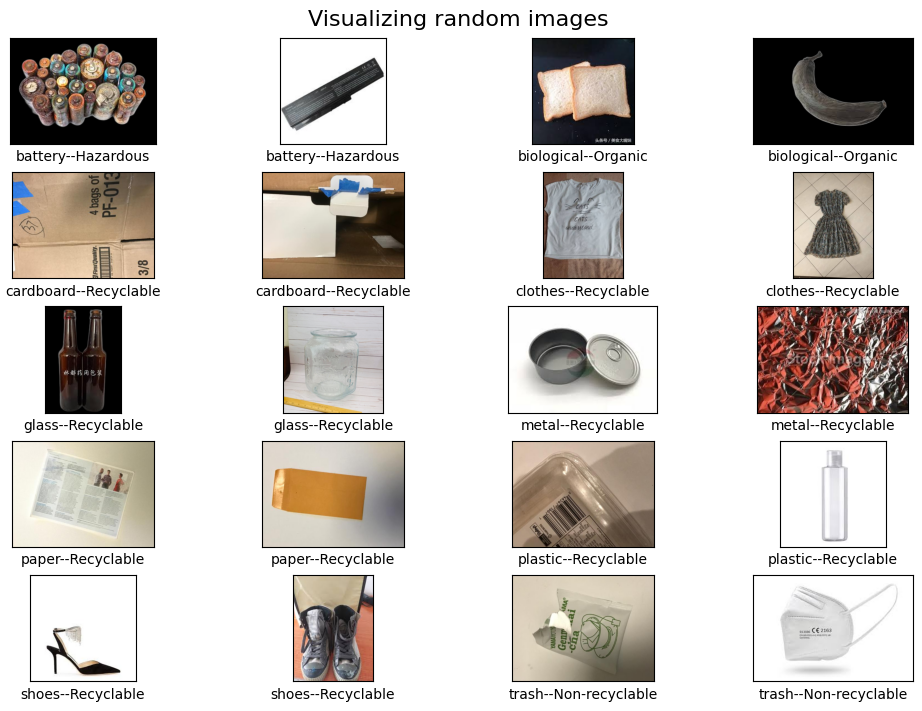

In [10]:
plt.figure(figsize = (10, 7), constrained_layout = True)
plt.suptitle('Visualizing random images', fontsize = 16)

position = 1

for class_name in DATASET:

    folder_path = os.path.join(DATASET_PATH, class_name)
    folder = os.listdir(folder_path)
    random_images = random.sample(folder, 2)

    for image_name in random_images:
        
        # Reading the image
        
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Plotting the image
    
        plt.subplot(5, 4, position)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(f'{class_name}--{CLASS_TO_CATEGORY[class_name]}')

        position += 1

plt.show()

<h1> 2.2. Dataset shapes </h1>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


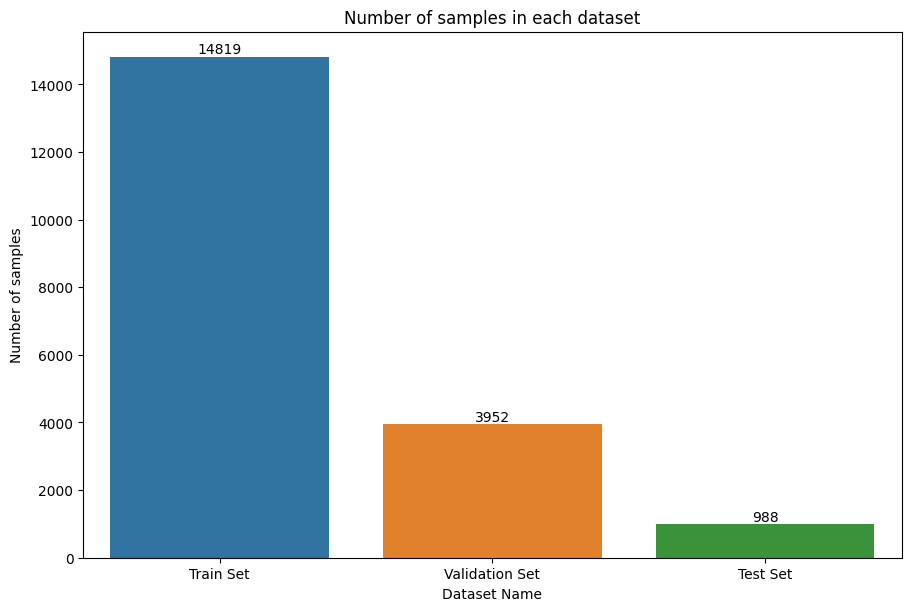

In [11]:
dataset_names = ['Train Set', 'Validation Set', 'Test Set']

dataset_shapes = [len(X_train), len(X_val), len(X_test)]
dataset_shapes = np.array(dataset_shapes, dtype = 'int32')

plt.figure(figsize = (9, 6), constrained_layout = True)

ax = sns.barplot(x = dataset_names, y = dataset_shapes)
ax.bar_label(ax.containers[0])

plt.xlabel('Dataset Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each dataset')

plt.show()

<h1> 2.3. Class Distribution </h1>

In [12]:
class_samples = pd.Series(labels).value_counts().sort_index()
print(class_samples)

0     944
1     997
2    1825
3    5327
4    3061
5    1020
6    1677
7    1984
8    1977
9     947
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


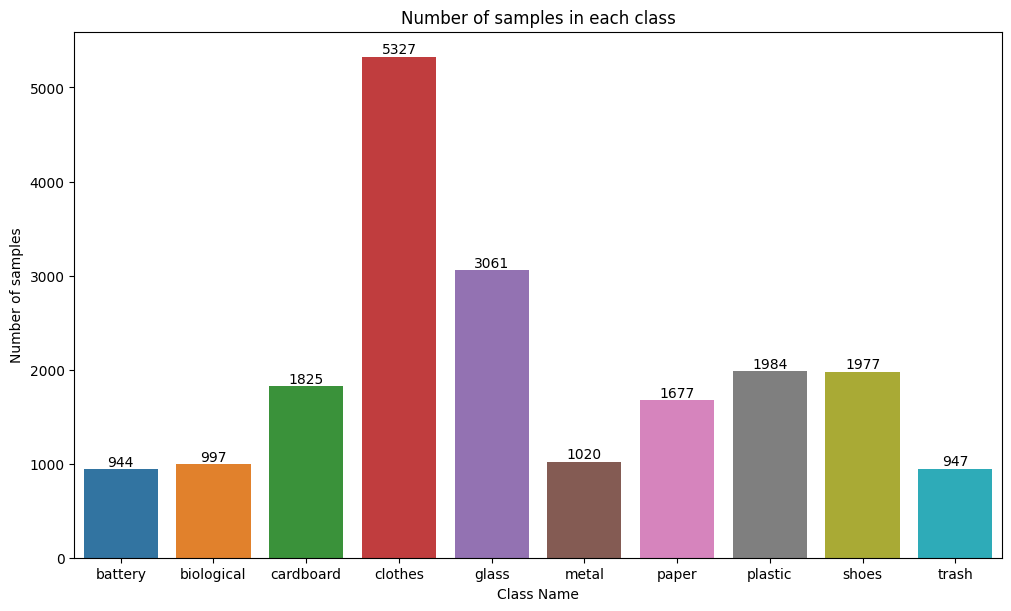

In [13]:
plt.figure(figsize = (10, 6), constrained_layout = True)

ax = sns.barplot(x = CLASSES, y = class_samples)
ax.bar_label(ax.containers[0])

plt.xlabel('Class Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each class')

plt.show()

<h1> 2.4. Class distribution using Pie Chart </h1>

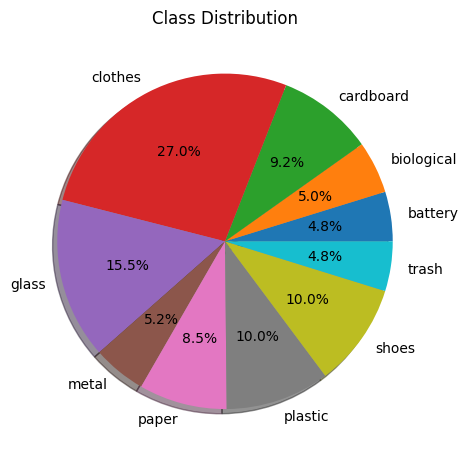

In [14]:
plt.figure(figsize = (6.5, 4.5), constrained_layout = True)

plt.pie(class_samples, labels = CLASSES, autopct = '%1.1f%%',
        pctdistance = 0.6, shadow = True)

plt.title('Class Distribution')
plt.show()

<h1> 2.5. Distribution of classes in each category </h1>

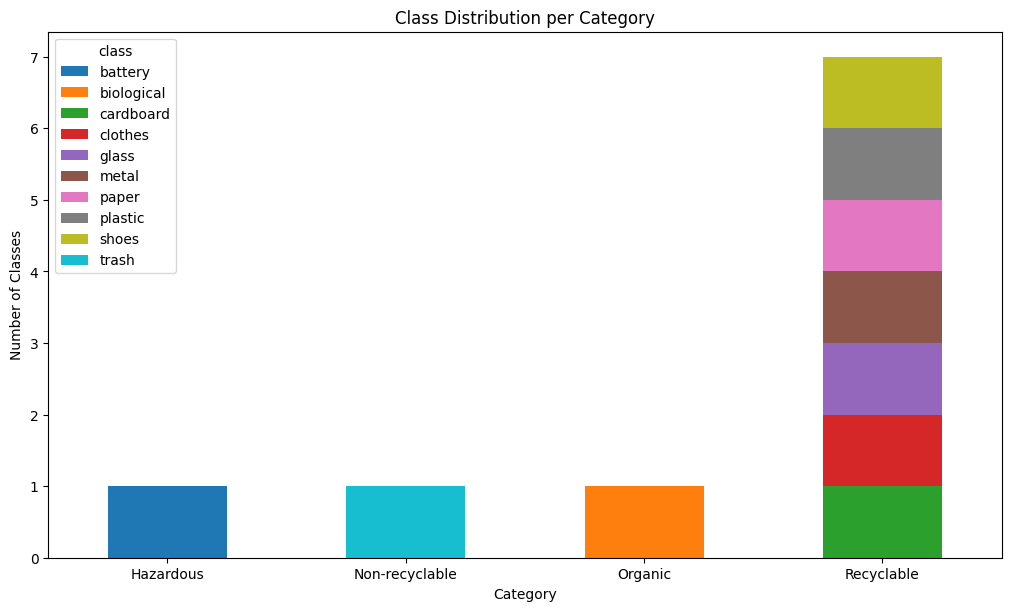

In [15]:
df = pd.DataFrame(CLASS_TO_CATEGORY.items(), columns=["class", "category"])
classes_count = df.groupby("category")["class"].value_counts().unstack()

fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True)
classes_count.plot(kind = "bar", stacked = True, ax = ax, colormap = "tab10")

ax.set_xlabel("Category")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_ylabel("Number of Classes")
ax.set_title("Class Distribution per Category")

plt.show()

<h1> 3. Model </h1>

<h1> 3.1. Defining the model </h1>

In [16]:
# Using the pre-trained ResNet model

base_model = keras.applications.ResNet50(

    include_top = False,
    weights = 'imagenet',
    pooling = POOLING_TYPE,
    input_shape = IMAGE_SHAPE
    
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
model = keras.models.Sequential([

    base_model,
    keras.layers.Dense(512, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
    
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

<h1> 3.2. Training the model </h1>

In [19]:
history = model.fit(
    
    train_ds,
    epochs = NUM_EPOCHS,
    validation_data = (val_ds),
    class_weight = class_weights,
    callbacks = [EARLY_STOPPING, REDUCE_LR]
    
)

Epoch 1/100


I0000 00:00:1747451266.688603      61 service.cc:148] XLA service 0x78731c005970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747451266.691959      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747451266.691982      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747451268.542283      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/464 ━━━━━━━━━━━━━━━━━━━━ 2:16:39 18s/step - accuracy: 0.0625 - loss: 27.2377

I0000 00:00:1747451274.354543      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


464/464 ━━━━━━━━━━━━━━━━━━━━ 89s 153ms/step - accuracy: 0.6372 - loss: 11.5674 - val_accuracy: 0.8869 - val_loss: 4.1134 - learning_rate: 0.0010
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.8279 - loss: 3.6615 - val_accuracy: 0.8889 - val_loss: 1.9631 - learning_rate: 0.0010
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.8623 - loss: 1.8899 - val_accuracy: 0.9071 - val_loss: 1.1725 - learning_rate: 0.0010
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.8617 - loss: 1.2454 - val_accuracy: 0.9190 - val_loss: 0.8384 - learning_rate: 0.0010
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.8698 - loss: 0.9604 - val_accuracy: 0.9261 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.8658 - loss: 0.8723 - val_accuracy: 0.9147 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.8597 

<h1> 3.3. Exporting Model Architecture and Weights </h1>

In [20]:
model.save('/kaggle/working/resnet50_custom.h5')

<h1> 4. Model Evaluation </h1>

<h1> 4.1. Training and Validation Accuracy </h1>

In [21]:
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

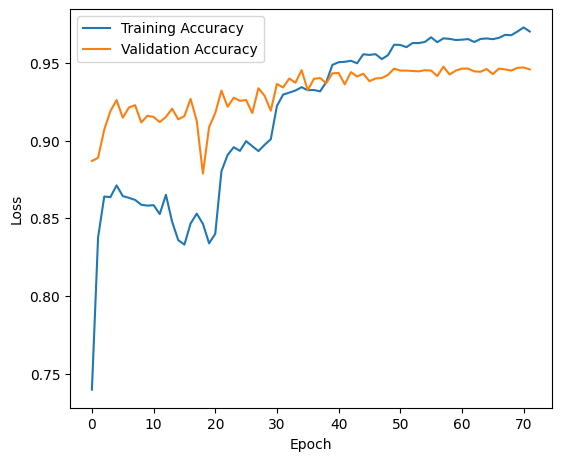

In [22]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [23]:
print(f'Train Accuracy: {round(train_accuracies[-1], 2) * 100}%')
print(f'Validation Accuracy: {round(val_accuracies[-1], 2) * 100}%')

Train Accuracy: 97.0%
Validation Accuracy: 95.0%


<h1> 4.2. Training and Validation Loss </h1>

In [24]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

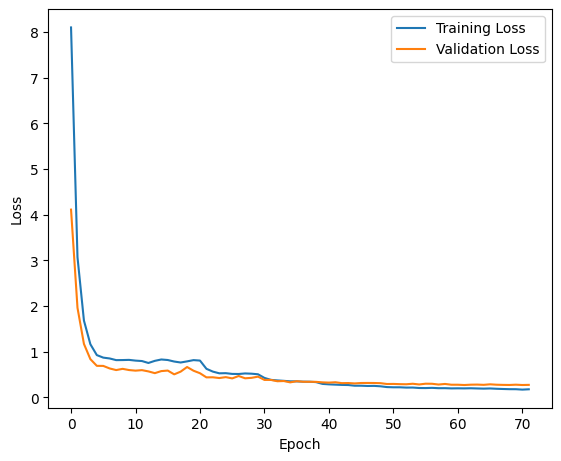

In [25]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [26]:
print(f'train Losses: {round(train_losses[-1], 2) * 100}%')
print(f'Validation Losses: {round(val_losses[-1], 2) * 100}%')

train Losses: 18.0%
Validation Losses: 28.000000000000004%


<h1> 4.3. Getting Predicted labels </h1>

In [27]:
y_val = np.concatenate([labels for imgs, labels in val_ds])

prob_arrays = model.predict(val_ds)
y_pred = [prob_arr.argmax() for prob_arr in prob_arrays]

print("Validation labels shape:", len(y_val))
print("Predict labels shape:", len(y_pred))

62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step
Validation labels shape: 3952
Predict labels shape: 3952


<h1> 4.4. Confusion Matrix </h1>

<Axes: >

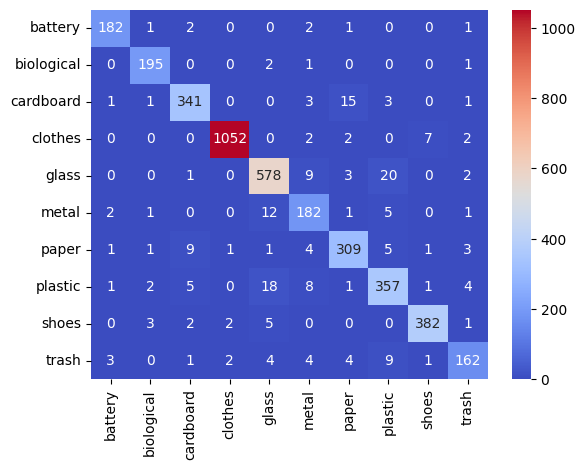

In [28]:
cm = metrics.confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'coolwarm', xticklabels = CLASSES, yticklabels = CLASSES)

<h1> 4.5. Classifcation Report </h1>

In [29]:
report = metrics.classification_report(y_val, y_pred, target_names = CLASSES)
print(report)

              precision    recall  f1-score   support

     battery       0.96      0.96      0.96       189
  biological       0.96      0.98      0.97       199
   cardboard       0.94      0.93      0.94       365
     clothes       1.00      0.99      0.99      1065
       glass       0.93      0.94      0.94       613
       metal       0.85      0.89      0.87       204
       paper       0.92      0.92      0.92       335
     plastic       0.89      0.90      0.90       397
       shoes       0.97      0.97      0.97       395
       trash       0.91      0.85      0.88       190

    accuracy                           0.95      3952
   macro avg       0.93      0.93      0.93      3952
weighted avg       0.95      0.95      0.95      3952



In [30]:
# Average Precision, Recall and F1 Scores

precision = metrics.precision_score(y_pred, y_val, average = 'weighted')
recall = metrics.recall_score(y_pred, y_val, average = 'weighted')
f1_score = metrics.f1_score(y_pred, y_val, average = 'weighted')

print(f'Precision Score = {round(precision, 2) * 100}%')
print(f'Recall Score = {round(recall, 2) * 100}%')
print(f'F1 Score = {round(f1_score, 2) * 100}%')

Precision Score = 95.0%
Recall Score = 95.0%
F1 Score = 95.0%


<h1> 4.6. Predicting Random Images </h1>

In [31]:
def predict(image_path):
    
    image = cv2.imread(image_path)
    
    # Processing the image
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_arr = np.expand_dims(image, axis = 0)
    image_arr = keras.applications.resnet.preprocess_input(image_arr)
    
    # Predicting the label
    prob_array = model.predict(image_arr, verbose = 0)
    label = prob_array.argmax()
    class_name = CLASSES[label]

    return image, class_name

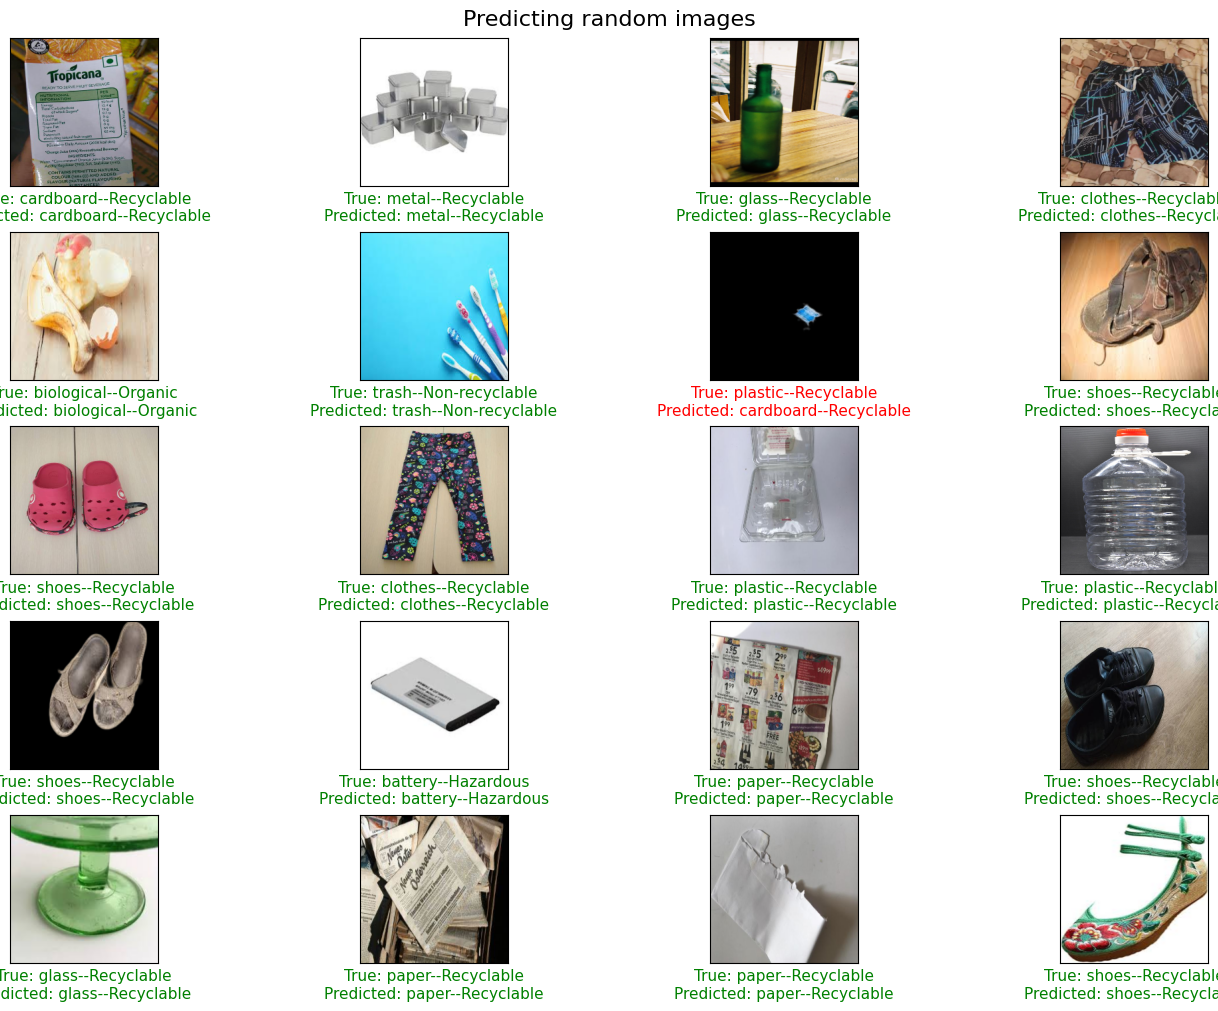

In [32]:
plt.figure(figsize = (14, 10), constrained_layout = True)
plt.suptitle('Predicting random images', fontsize = 16)

for ind in range(20):

    # Getting true values 
    image_path = X_test[ind]
    true_label = CLASSES[y_test[ind]]

    # Getting predicted values
    image, pred_label = predict(image_path)

    # Preparing the subplot
    plt.subplot(5, 4, ind + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Displaying the image
    plt.imshow(image)

    # Checking true and predicted values match 
    
    true_str = f'True: {true_label}--{CLASS_TO_CATEGORY[true_label]}'
    pred_str = f'Predicted: {pred_label}--{CLASS_TO_CATEGORY[pred_label]}'
    
    xlabel_str = f'{true_str}\n{pred_str}'
    color = 'green' if true_label == pred_label else 'red'
    
    plt.xlabel(xlabel_str, color = color, fontsize = 11)

plt.show()